# Question 1

In this question we will:

- Design and implement a feature that can be used to creates a feature map sensitive to "greenness".
- Utilize thresholding techniques of this "greenness" feature to obtain a segmentation of green leaves in images with a cluttered background.
- Implement evaluation metrics to measure the quality of a segmentation produced by the thresholding
- Use the metrics to evaluate the segmentation algoirthm's perormance on a dataset of images of green leaves on a cluttered background.

# Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding.  Determine a metric that can be used to meaure the "greenness" of the colour of a given pixel.  Your algoirthm should create a "feature map" by computing this feature for each pixel, thus creating an "image" where each pixel's "intensity" is the value of the "greenness" feature.   Then use a thresholding method of your choice to segment the image's green regions.    You should also consider whether doing some region processing after segmentation can improve the results.  This function should return the segmenetion of the image as a binary image with a single connected component since you can take advantage of the fact that each image is known to contain only a single leaf.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_

In [1]:
import numpy as np
from skimage.color import rgb2hsv
from skimage import filters, morphology
from scipy.ndimage import binary_fill_holes

def segleaf(I):
    R, G, B = I[:, :, 0], I[:, :, 1], I[:, :, 2]

    # use normalized colour channels to find places that are majority green
    S = R + G + B + 1e-8
    r, g, b = R / S, G / S, B / S
    exg_c = 2.0 * g - r - b

    # Ensure the values are scaled between 0 and 1 
    lo, hi = np.percentile(exg_c, (0, 100))
    F = np.clip((exg_c - lo) / (hi - lo + 1e-8), 0.0, 1.0)

    # Single global threshold on full feature
    t = filters.threshold_otsu(F)
    mask = F >= t

    # Near-white mask for removing light backgrounds 
    H, S_hsv, V = rgb2hsv(I).transpose(2, 0, 1)
    near_white = (S_hsv < 0.12) & (V > 0.85)

    # make a mask of places where the value of green is bigger than red and blue
    mask &= (G >= R) & (G >= B)
    # remove any of the places where that overlaps with the places most likely to be white
    mask[near_white] = False

    # fill and holes in the masks then select the largest if multiple still exist (since theres always 1 leaf)
    mask = binary_fill_holes(mask)
    lbl = morphology.label(mask, connectivity=2)
    if lbl.max() > 0:
        cnt = np.bincount(lbl.ravel()); cnt[0] = 0
        mask = (lbl == np.argmax(cnt))
    return mask

213
0.8352941176470589
(592, 896, 3)
uint8
(592, 896)
uint8
bool


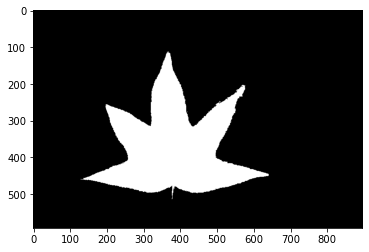

In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float

test_img = imread("images\image_0009.png")

print(test_img[...,0][0,0])
print(img_as_float(test_img[...,0][0,0]))

gtruth_img = imread("groundtruth\image_0161.png")
print(test_img.shape)
print(test_img.dtype)
print(gtruth_img.shape)
print(gtruth_img.dtype)

mask = segleaf(img_as_float(test_img))
print(mask.dtype)
plt.imshow(mask, cmap='gray')

# Step 2: Implement Segmentation Performace Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [163]:
from skimage.segmentation import find_boundaries
from scipy.spatial import cKDTree

def dice(seg, gt):
    seg = seg.astype(bool)
    gt  = gt.astype(bool)
    inter = np.logical_and(seg, gt).sum()
    denom = seg.sum() + gt.sum()
    return (2.0 * inter) / (denom + 1e-8)

def boundary_coords(mask_bool):
    b = find_boundaries(mask_bool.astype(bool), mode='outer')
    return np.column_stack(np.nonzero(b))  # shape (N, 2) with rows [r, c]

def nearest_neighbor(A, B):
    # for each value in B find the nearest neighbor in A
    if A.size == 0 or B.size == 0:
        raise ValueError ("One or both arrays are length 0, a nearest neighbor search cannot be performed")
    treeG = cKDTree(A)
    # Uses all CPU threads to complete search
    d, _ = treeG.query(B, workers = -1)
    return d

def msd_hd(seg_mask, gt_mask):
    A = boundary_coords(seg_mask)  # points on segmented boundary
    G = boundary_coords(gt_mask)   # points on ground‑truth boundary

    msd = float(np.mean(nearest_neighbor(G, A)**2)) 

    hd = max(np.max(nearest_neighbor(G,A)), np.max(nearest_neighbor(A,G)))

    return [msd, hd]

# Step 3: Write a Validation driver program.

Write code that segments each image (using the function in Step 1), and computes the MSD, HD, and DSC for each segmentation (using the functions in Step 2).  Print the MSD, HD, and DSC of each segmentation to the console as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD, and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image:

* load the image and it's ground truth (use the provided leaf image dataset, described in section 2.2. of the assignment PDF) -- a .csv file is provided with the names of all images so that you can process the files in the same manner as Assignment 1, question 1)
* segment the input image using your function from Step 1
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture notes Topic 6, slide 68 for an example on how to do this).
* Compute the MSD and the HD from the two sets of boundary points (using the appropriate functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the appropriate function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished processing each image, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [160]:
import pandas as pd
from skimage.io import imread
from skimage.util import img_as_float

files = pd.read_csv("images.csv", header=None)
png_list = files[0].tolist()

images = [img_as_float(imread(f"images\{png}")) for png in png_list] # Colour images of leaves
groundtruths = [img_as_float(imread(f"groundtruth\{png}")) > 0.5 for png in png_list] # Boolean mask of ground truths

segments = [segleaf(image) for image in images] # Boolean mask of leave images made by my algorithm

dscs = [dice(segment, groundtruth) for segment, groundtruth in zip(segments, groundtruths)] # List of dice values
msds_hds = [msd_hd(segment, groundtruth) for segment, groundtruth in zip(segments, groundtruths)] # List of List of msd and hd values

recognized = [dsc > 0.6 for dsc in dscs]  # List of booleans stating whether a leaf was or wasnt recognized (ie dsc was > 0.6)

for fname, dsc, m_h in zip(png_list, dscs, msds_hds):
    print(f"DSC for {fname}: {dsc}")
    print(f"MSD for {fname}: {m_h[0]}")
    print(f"HD for {fname}: {m_h[1]}")
    print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

print(f"The mean Dice coefficient was: {np.mean(dscs)}")
print(f"The std. deviation of Dice coefficient was: {np.std(dscs)}")
print(f"The mean MSD was: {np.mean(msds_hds[0])}")
print(f"The std. deviation of MSD was: {np.std(msds_hds[0])}")
print(f"The mean HD was: {np.mean(msds_hds[1])}")
print(f"The std. deviation of HD was: {np.std(msds_hds[1])}")
print(f"{np.mean(recognized)*100}% of leaves were recognized")

DSC for image_0001.png: 0.998651453653569
MSD for image_0001.png: 0.20875251509054327
HD for image_0001.png: 6.324555320336759
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0002.png: 0.9985642353035665
MSD for image_0002.png: 0.11515969410706253
HD for image_0002.png: 5.0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0005.png: 0.9986616064388953
MSD for image_0005.png: 0.15391705069124423
HD for image_0005.png: 3.1622776601683795
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0007.png: 0.9979656498812711
MSD for image_0007.png: 72.9275092936803
HD for image_0007.png: 61.032778078668514
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0009.png: 0.9986024469882098
MSD for image_0009.png: 0.7169171110033932
HD for image_0009.png:

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


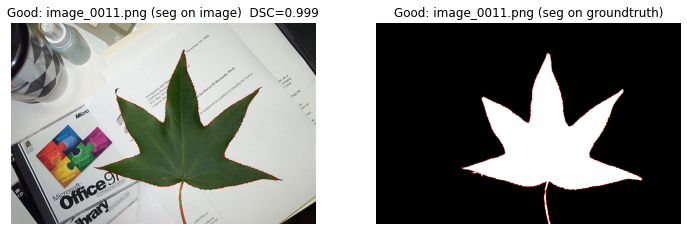

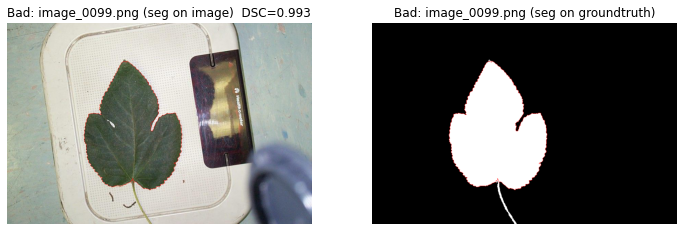

In [ ]:
import matplotlib.pyplot as plt

def overlay_contour(image, mask, color=(1, 0, 0)):
    b = find_boundaries(mask, mode='outer')
    out = image.copy()
    out = img_as_float(out)
    rr, cc = np.nonzero(b)
    out[rr, cc, :] = color
    return out

# Using DSC for criteria
best_idx = np.argmax(dscs)
worst_idx = np.argmin(dscs)

for label, idx in [('Good', best_idx), ('Bad', worst_idx)]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(overlay_contour(images[idx], segments[idx]))
    axes[0].set_title(f'{label}: {png_list[idx]} (seg on image)  DSC={dscs[idx]:.3f}')
    axes[0].axis('off')
    gt_rgb = np.dstack([groundtruths[idx], groundtruths[idx], groundtruths[idx]]).astype(float)
    axes[1].imshow(overlay_contour((gt_rgb*255).astype(np.uint8), segments[idx]))
    axes[1].set_title(f'{label}: {png_list[idx]} (seg on groundtruth)')
    axes[1].axis('off')
    plt.show()


# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	* Each colour channel is extracted from the image and normalized (the +1e8 is to make sure theres no divisions by 0). 
	* Then, the normalized colour channels are combined to determine the "Excessive Green Index" which gives an array of values stating how much larger the green in a pixel was than the combined red and blue. This value can range from -510 to 510 since you could have 255 green with 0 red and blue or vice versa, so the values scaled back down to a range between 0 and 1. 
	* From here an otsu thresholding is performed and a mask of the image is generated. 
	* After all this I was running into the issue where the lighter coloured (especially white) backgrounds would sometimes meld with my leaves. To solve this, I make a "near white" mask by thresholding regions where saturation is low and value is high (near white in HSV). 
	* Then I perform a bitwise AND between the otsu threshold mask and the the places where green was the dominant colour, in order to ensure we are still looking at predominantly green pixels. 
	* Then I remove the near white mask from this joint otsu/green mask since places that are white could be predominantly green, but they won't be leaves. 
	* Finally I fill any holes in the mask, label the various regions using 8-connectivity, and return the largest of the masks since the leave is the largest green thing in every image.
	
2. Consider your example "good" result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	* I think the only way to impove this would be to be able to detect the browning tips of the leaf, but that would require something more robust than thresholding. Most likely I could introduce some sort of random walk algorithm that could reach those tips. However this would actually result in worse DICE values since the ground truth didn't include them.

3. Consider your example "bad" result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	* For this one photo in particular it seems my algorithm ignores the stem. I would assume the multistep thresholding is resulting in two separate masks extremely close together, but since I don't and dilation, erosion, etc, the two masks never connect and it gets left out. I could potentially solve this with a closing but I would worry about the overall loss of quality due to the decreased edge resolution.